In [1]:
import quf
import numpy as np
from numpy import prod
import quimb as qu
from autoray import do
from quimb.tensor import *
from quimb.tensor.tensor_core import *


In [2]:
def apply_I(tn,where_in, where_out, n_layer,tags_I,list_scale,scale=0,chi_out=None,seed_val=0,dist_type="uniform",data_type="float64"):
  n_layer[0]+=1
  list_scale.append(f"SI{scale}")

  if   chi_out:
        dims_out=chi_out
  else: 
        dims_out =[ tn.ind_size(tn.layer_ind(*coo)) for coo in where_out ]

  dims_in =[tn.ind_size(tn.layer_ind(*coo)) for coo in where_in] 

  #if len(chi_out) != len(dims_out):
     #print ("warning", "where_out != chi_out")


  print (prod(dims_out), prod(dims_out), dims_out , dims_in)
  if prod(dims_out)>prod(dims_in):
       print ("Warning", "prod(dims_out)>prod(dims_out)",dims_out , dims_in)


  dims=   dims_out + dims_in

  #print (dims)
  if seed_val==0 and prod(dims_out)==prod(dims_in) :
        G_v=qu.eye( int(prod(dims)**(1./2.)), dtype=data_type).reshape( dims )
        G_r=qu.randn(dims,dtype=data_type, dist=dist_type, seed=seed_val)
        G_v=G_v+G_r*(0.1)
  else:
        G_v=qu.randn(dims,dtype=data_type, dist=dist_type, seed=seed_val)
    
  tags_I.append(f"I{n_layer[0]}")
  tn.reverse_gate(
          G=qu.randn(dims,dtype=data_type, dist=dist_type, seed=seed_val ), 
          where=where_in,
          iso=True,
          tags=["I",f"I{n_layer[0]}",f"SI{scale}"],
          new_sites=where_out
       )


def apply_U(tn,where_in,where_out, n_layer,tags_U,list_scale,scale=0,chi_out=None,seed_val=0,dist_type="uniform",data_type="float64"):
  n_layer[1]+=1
  dims_out =[tn.ind_size(tn.layer_ind(*coo)) for coo in where_out]
  dims_in =[tn.ind_size(tn.layer_ind(*coo)) for coo in where_in] 
  list_scale.append(f"SI{scale}")

  if chi_out:
        dims_out=chi_out        
  if prod(dims_out)>prod(dims_in):
        print ("Warning", "prod(dims_out)>prod(dims_in)", dims_out , dims_in)   
    
  dims=   dims_out + dims_in
  #print ("U",dims)
  if seed_val==0 and prod(dims_out)==prod(dims_in) :
        G_v=qu.eye( int(prod(dims)**(1./2.)), dtype=data_type).reshape( dims )
        G_r=qu.randn(dims,dtype=data_type, dist=dist_type, seed=seed_val)
        G_v=G_v+G_r*(0.1)
  else:
        G_v=qu.randn(dims,dtype=data_type, dist=dist_type, seed=seed_val)
    
  tags_U.append(f"U{n_layer[1]}")
  tn.reverse_gate(
          G=qu.randn(dims,dtype=data_type, dist=dist_type, seed=seed_val ), 
          where=where_in,
          iso=True,
          tags=["U",f"U{n_layer[1]}",f"SI{scale}"],
          new_sites=where_out
       )



In [3]:
tn_minat,list_sites, list_inter,list_tags_I, list_tags_U,list_scale=quf.MiniatureTN_build_three(phys_dim=2,chi=4,chi_p=10,chi_pp=7,cycle_u="False",data_type="float64",dist_type="uniform")

N_x, N_y, N_z 48 1 1 chi 4 chi_p 10 chi_pp 7


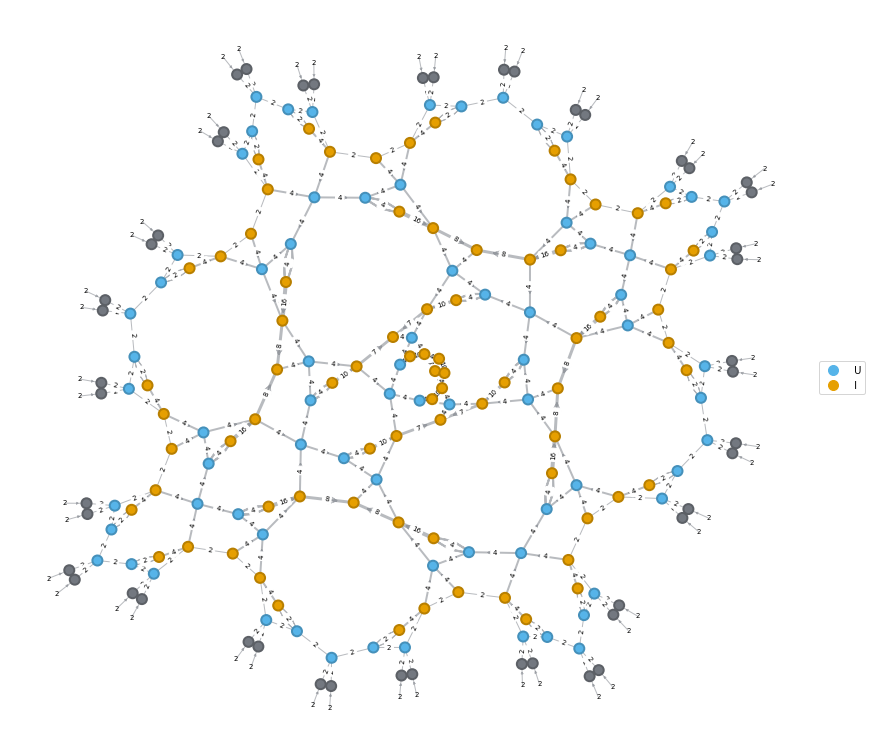

In [4]:
tn_minat.draw(["U", "I"],show_tags=False,show_inds='bond-size',  figsize=(12, 12),  return_fig=False,node_size=100 , edge_scale=1 )

In [5]:
method="pad"
rand_strength_u=0.001
#rand_padder=
chi_check=[4]
chi_new=12
whole_inds=[]
for t in tn_minat:
    right_inds = list( set(t.inds) - set(t.left_inds) )
    for i in right_inds:
       whole_inds.append(i)
    
#print (whole_inds)   
if len(whole_inds) == len(set(whole_inds)):
    print ("no duplicate")
    


no duplicate


In [6]:
def  increase_bond(rand_strength_u,ind_t, list_ten_local,method,left_inds_0):
                    pads = [(0, 0) if i not in ind_t else
                                    (0, max(chi_new - d, 0))
                                    for d, i in zip(list_ten_local.shape, list_ten_local.inds)]
                    if method=="pad" :
                        if rand_strength_u > 0 :
                          edata = do('pad', list_ten_local.data, pads, mode=rand_padder,
                                     rand_strength=rand_strength_u)
                        else:
                          edata = do('pad', list_ten_local.data, pads, mode='constant')

                    list_ten_local.modify(data=edata)
                    list_ten_local.modify(left_inds=left_inds_0)


In [7]:
inds_expanded=[]
while whole_inds:    
    inds_expanded=[] 
    for ind_t in whole_inds:
        list_ten_local=[]
        for i in  tn_minat.ind_map[ind_t] :
            list_ten_local.append( tn_minat.tensor_map[i])


        left_inds_0 = list( set(list_ten_local[0].left_inds) )
        left_inds_1 = list( set(list_ten_local[1].left_inds) )

        for t_l in list_ten_local:
         if ind_t not in t_l.left_inds:
             #print ("Hi")
             #check:
             size_ind_t=tn_minat.ind_size(ind_t)          
             if chi_new >  size_ind_t:
                 #print (chi_new,  tn_minat.ind_size(ind_t))
                 right_inds = list( set(t_l.inds) - set(t_l.left_inds) )
                 #print (right_inds)

                 right_inds.remove(ind_t)   
                 #print (right_inds)
                 left_inds = list( set(t_l.left_inds) )
                 chi_in=int(np.prod([ tn_minat.ind_size(i)  for i in left_inds]))
                 chi_o=int(np.prod([ tn_minat.ind_size(i)  for i in right_inds]))
                 chi_o=chi_o*chi_new
                 #print (chi_o, chi_in)
                 if chi_o<=chi_in and size_ind_t not in chi_check:
                        #print ("H")
                        inds_expanded.append(ind_t)
                        increase_bond(rand_strength_u,ind_t, list_ten_local[0],method,left_inds_0)
                        increase_bond(rand_strength_u,ind_t, list_ten_local[1],method,left_inds_1)

    print (inds_expanded)
    whole_inds = list( set(whole_inds) - set(inds_expanded) )
    if not inds_expanded:
        break
        
        

['_b233efAAAEA', '_b233efAAAEB', '_b233efAAAEK', '_b233efAAAEL', '_b233efAAAEU', '_b233efAAAEV', '_b233efAAAEe', '_b233efAAAEf', '_b233efAAAFF', '_b233efAAAFH', '_b233efAAAFI', '_b233efAAAFJ', '_b233efAAAFP', '_b233efAAAFR', '_b233efAAAFS', '_b233efAAAFT', '_b233efAAAFj', '_b233efAAAFl', '_b233efAAAFm', '_b233efAAAFn', '_b233efAAAFq']
[]


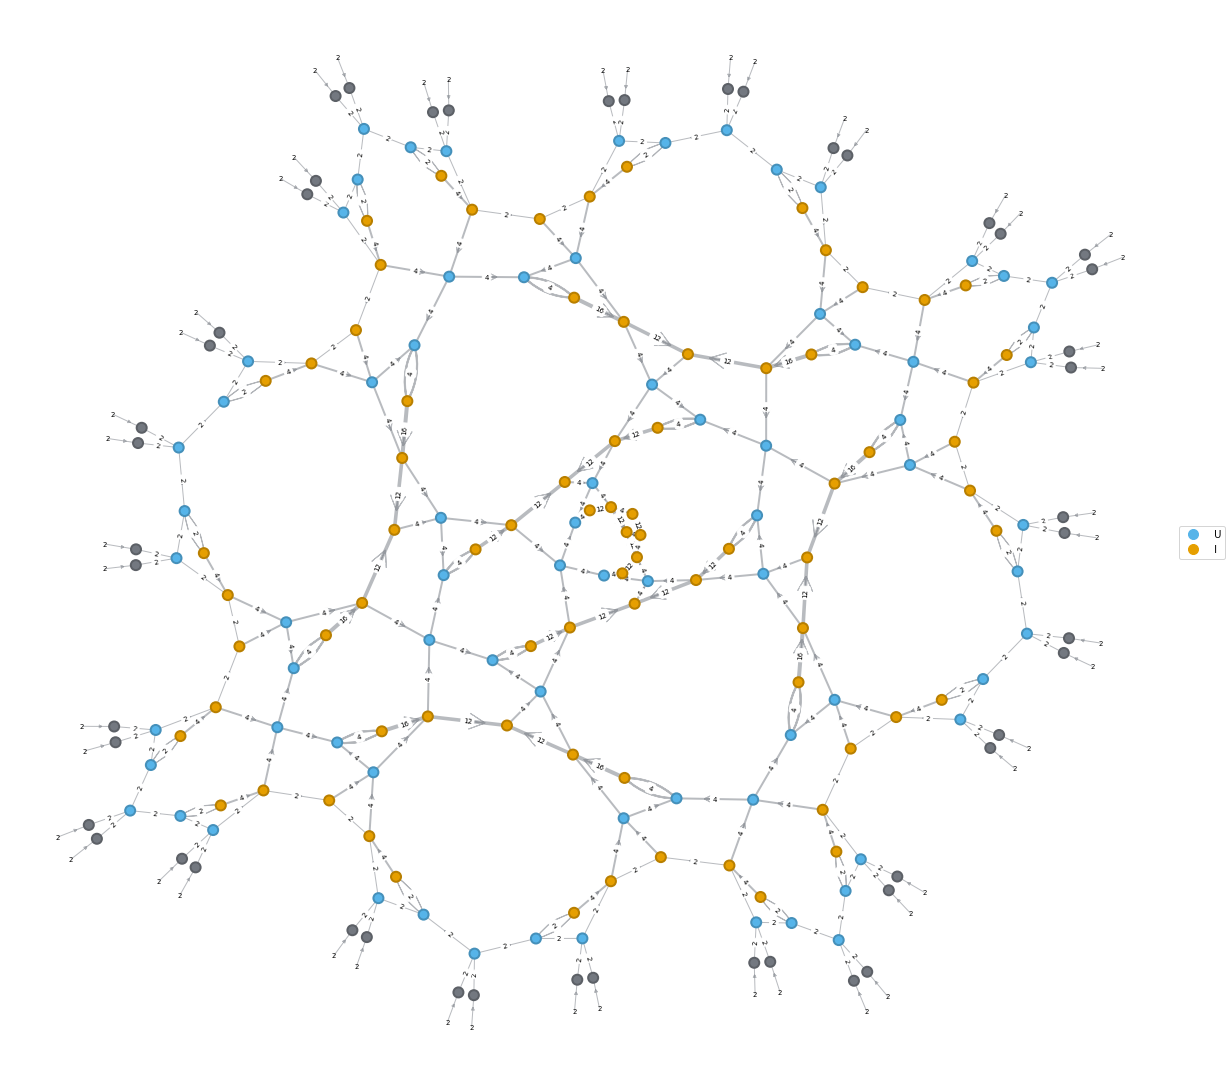

In [9]:
tn_minat.draw(["U", "I"],show_tags=False,show_inds='bond-size',  figsize=(17, 17),  return_fig=False,node_size=100 , edge_scale=1 )